<a href="https://colab.research.google.com/github/sarvadutt/Unsupervised-Anomaly-Detection-in-Network-Data/blob/main/%20Anomaly-Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# ***Analysing Data Set***

In [ ]:
df = pd.read_csv("Machin_learning_based_encrypted_malicious_and_legitimate_traffic_dataset.csv")
df.head()

,session,Flag_of_packets,Traffic_sequence,Payload_ratio,Length_of_IP_packets,Length_of_TCP_payload,Length_of_TCP_packet_header,Length_of_IP_packet_header,TCP_windows_size_value,Length_of_TCP_segment(packet),...,std_backward_pkt_length,duration_forward,duration_back,mean_of_backward_IP_header,mean_of_forward_IP_header,total_payload_per_session,IPratio,Goodput,source_IP_address,Destination_IP_address
0,1,24,1054741384,0.908612,569,517,32,20,1369,549,...,48.804901,1028.790806,1028.791156,20.0,20.0,1470.0,10.942308,2.808822,10.42.0.211,209.85.201.188
1,1,24,1450143304,0.727749,191,139,32,20,340,171,...,48.804901,1028.790806,1028.791156,20.0,20.0,1470.0,10.942308,2.808822,10.42.0.211,209.85.201.188
2,1,24,1054741901,0.452632,95,43,32,20,1386,75,...,48.804901,1028.790806,1028.791156,20.0,20.0,1470.0,10.942308,2.808822,10.42.0.211,209.85.201.188
3,1,24,1054741944,0.860215,372,320,32,20,1386,352,...,48.804901,1028.790806,1028.791156,20.0,20.0,1470.0,10.942308,2.808822,10.42.0.211,209.85.201.188
4,1,24,1450143443,0.297297,74,22,32,20,349,54,...,48.804901,1028.790806,1028.791156,20.0,20.0,1470.0,10.942308,2.808822,10.42.0.211,209.85.201.188


# **Knowing the columns and they data types**

In [ ]:

column_info = df.dtypes

for column_name, data_type in column_info.items():
    print(f"Column: {column_name}, Data Type: {data_type}")


# **one-hot encoding**

In [ ]:

object_columns = df.select_dtypes(include=['object'])

dat= pd.get_dummies(df, columns=object_columns.columns)

# ***Train and Test sets***

In [ ]:
train,test = np.split(dat.sample(frac=1), [int(0.8*len(df))])

# ***pre-porocessing Data( for Unsupervised )***

In [ ]:
input_columns = dat.columns.drop('label').tolist()
def preprocess_data(datafram):

    X = datafram[input_columns]

    reshaped_array = np.reshape(X, (X.shape[0], -1))  # Reshape X to (number of samples, -1)
    X = np.hstack((X, reshaped_array))

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return X

In [ ]:

X_train = preprocess_data(train)


X_test = preprocess_data(test)


## Dimensions Reduction Using PCA & TSNE

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
from sklearn.pipeline import Pipeline

def find_best_pca_components(X_train, explained_variance_threshold=0.95):
    n_features = X_train.shape[1]
    n_components = n_features  # Initialize n_components with the total number of features
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(explained_variance >= explained_variance_threshold) + 1
    return n_components

def apply_pca_tsne(X_train, X_test, pca_components=0.95, tsne_components=2):
    best_n_pca_components = find_best_pca_components(X_train, explained_variance_threshold=pca_components)

    pca = PCA(n_components=best_n_pca_components)
    tsne = TSNE(n_components=tsne_components)

    X_train = tsne.fit_transform(pca.fit_transform(X_train))
    X_test= tsne.fit_transform(pca.transform(X_test))

    return X_train, X_test

X_train, X_test = apply_pca_tsne(X_train, X_test, pca_components=0.95, tsne_components=2)

## Visualizing The Reduction

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Dimensionality reduction with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_train)  # Replace 'X' with your data

# Dimensionality reduction with t-SNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(X_train)  # Replace 'X' with your data

# Plot PCA and t-SNE results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.title('PCA')

plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.title('t-SNE')

plt.show()


In [ ]:
from sklearn.impute import SimpleImputer


imputer = SimpleImputer(strategy='mean')


X_train = imputer.fit_transform(X_train)
X_test =  imputer.fit_transform(X_test)

# ***Cheking For Suitable  Model***

# K-***Means Clustering***

In [ ]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=3 , n_init=20)


kmeans.fit(X_train)

cluster_labels = kmeans.predict(X_test)

<function matplotlib.pyplot.show(close=None, block=None)>

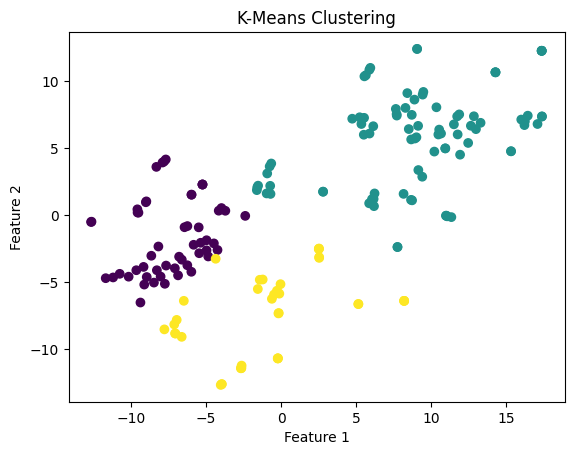

In [ ]:
# Analysing

plt.scatter(X_test[:, 0], X_test[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-Means Clustering')
plt.show

Calculateing silhouette, davies bouldin, calinski harabas

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


# Evaluate the clustering using Silhouette Score
silhouette_avg = silhouette_score(X_test, cluster_labels)
print("Silhouette Score:", silhouette_avg)

# Evaluate the clustering using Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X_test, cluster_labels)
print("Davies-Bouldin Index:", davies_bouldin)

# Evaluate the clustering using Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(X_test, cluster_labels)
print("Calinski-Harabasz Index:", calinski_harabasz)


Silhouette Score: 0.46064425
Davies-Bouldin Index: 0.8316496776801291
Calinski-Harabasz Index: 248.750894065014


# ***Auto Encoder Model***

In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Function to train the autoencoder
def train_autoencoder(X_train, encoding_dim, epochs, batch_size):
    input_dim = X_train.shape[1]

    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation='relu')(input_layer)
    decoder = Dense(input_dim, activation='sigmoid')(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)

    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, shuffle=True)

    return autoencoder


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


encoding_dims = [32, 64, 128]
epochs_values = [50, 100, 200]
batch_sizes = [32, 64, 128]


best_score = float('inf')
best_autoencoder = None
best_params = {}

for encoding_dim in encoding_dims:
    for epochs in epochs_values:
        for batch_size in batch_sizes:
            # Train autoencoder
            autoencoder = train_autoencoder(X_train, encoding_dim, epochs, batch_size)

            # Calculate reconstruction error
            encoded_X_test = autoencoder.predict(X_test)
            reconstruction_error_mse = mean_squared_error(X_test, encoded_X_test)
            reconstruction_error_mae = mean_absolute_error(X_test, encoded_X_test)
            reconstruction_error_r2 = r2_score(X_test, encoded_X_test)
            reconstruction_error = np.sqrt(reconstruction_error_mse)

            # Score the model based on the error metrics, you can choose the one that suits your needs
            score = reconstruction_error  # Use the reconstruction error for scoring

            if score < best_score:
                best_score = score
                best_autoencoder = autoencoder
                best_params = {
                    'encoding_dim': encoding_dim,
                    'epochs': epochs,
                    'batch_size': batch_size
                }

# The best_autoencoder now represents your best model for anomaly detection.
best_encoding_dim = best_params['encoding_dim']
best_epochs = best_params['epochs']
best_batch_size = best_params['batch_size']


 ***# Calculateing silhouette, davies bouldin, calinski harabas***


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Create an autoencoder with the best hyperparameters

best_autoencoder = train_autoencoder(X_train, best_params['encoding_dim'], best_params['epochs'], best_params['batch_size'])

# Encode your data
encoded_X_train = best_autoencoder.predict(X_train)
encoded_X_test = best_autoencoder.predict(X_test)

# Calculate Silhouette Score
silhouette_score_value = silhouette_score(encoded_X_test, cluster_labels)

# Calculate Davies-Bouldin Index
davies_bouldin_index = davies_bouldin_score(encoded_X_test, cluster_labels)

# Calculate Calinski-Harabasz Index
calinski_harabasz_index = calinski_harabasz_score(encoded_X_test, cluster_labels)

# Print the evaluation metrics
print("Silhouette Score:", silhouette_score_value)
print("Davies-Bouldin Index:", davies_bouldin_index)
print("Calinski-Harabasz Index:", calinski_harabasz_index)


# Hybrid Model

In [ ]:
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans

# Function to train the hybrid Autoencoder
def train_hybrid_autoencoder(X_train, encoding_dim, epochs, batch_size, cluster_labels_train):
    input_dim = X_train.shape[1]

    # Input layers for data and K-Means cluster labels
    data_input = Input(shape=(input_dim,))
    cluster_input = Input(shape=(1,))  # Assuming 1 cluster label per sample

    # Encoder for data
    data_encoder = Dense(encoding_dim, activation='relu')(data_input)
    # Merge the data-encoded features with cluster labels
    merged = Concatenate()([data_encoder, cluster_input])

    # Decoder
    decoder = Dense(input_dim, activation='sigmoid')(merged)

    # Autoencoder model
    autoencoder = Model(inputs=[data_input, cluster_input], outputs=decoder)

    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit([X_train, cluster_labels_train], X_train, epochs=epochs, batch_size=batch_size, shuffle=True)

    return autoencoder

# Grid search hyperparameters
encoding_dims = [32, 64, 128]
epochs_values = [50, 100, 200]
batch_sizes = [32, 64, 128]

best_score = float('inf')
best_autoencoder = None
best_params = {}

# Train K-Means clustering on the X_train dataset
kmeans = KMeans(n_clusters=5, n_init=30)
cluster_labels_train = kmeans.fit_predict(X_train)

# Iterate over hyperparameters
for encoding_dim in encoding_dims:
    for epochs in epochs_values:
        for batch_size in batch_sizes:
            # Train the hybrid Autoencoder
            autoencoder = train_hybrid_autoencoder(X_train, encoding_dim, epochs, batch_size, cluster_labels_train)

            # Compute cluster labels for X_test using the same K-Means model
            cluster_labels_test = kmeans.predict(X_test)

            # Evaluate the hybrid Autoencoder (use any scoring metric you prefer)
            encoded_X_test = autoencoder.predict([X_test, cluster_labels_test])
            reconstruction_error_mse = mean_squared_error(X_test, encoded_X_test)

            if reconstruction_error_mse < best_score:
                best_score = reconstruction_error_mse
                best_autoencoder = autoencoder
                best_params = {
                    'encoding_dim': encoding_dim,
                    'epochs': epochs,
                    'batch_size': batch_size
                }

# The best_autoencoder now represents your best hybrid model for anomaly detection.
best_encoding_dim = best_params['encoding_dim']
best_epochs = best_params['epochs']
best_batch_size = best_params['batch_size']



***# Calculateing silhouette, davies bouldin, calinski harabas***

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Create an autoencoder with the best hyperparameters
best_autoencoder = train_hybrid_autoencoder(X_train, best_encoding_dim, best_epochs, best_batch_size, cluster_labels_train)

# Compute cluster labels for X_test using the same K-Means model
cluster_labels_test = kmeans.predict(X_test)

# Encode your data using the best hybrid autoencoder
encoded_X_train = best_autoencoder.predict([X_train, cluster_labels_train])
encoded_X_test = best_autoencoder.predict([X_test, cluster_labels_test])

# Calculate Silhouette Score
silhouette_score_value = silhouette_score(encoded_X_test, cluster_labels_test)

# Calculate Davies-Bouldin Index
davies_bouldin_index = davies_bouldin_score(encoded_X_test, cluster_labels_test)

# Calculate Calinski-Harabasz Index
calinski_harabasz_index = calinski_harabasz_score(encoded_X_test, cluster_labels_test)

# Print the evaluation metrics
print("Silhouette Score:", silhouette_score_value)
print("Davies-Bouldin Index:", davies_bouldin_index)
print("Calinski-Harabasz Index:", calinski_harabasz_index)


Epoch 1/200
23/23 [==============================] - 1s 3ms/step - loss: 319.0551
Epoch 2/200
23/23 [==============================] - 0s 6ms/step - loss: 311.8282
Epoch 3/200
23/23 [==============================] - 0s 6ms/step - loss: 311.4040
Epoch 4/200
23/23 [==============================] - 0s 6ms/step - loss: 311.2964
Epoch 5/200
23/23 [==============================] - 0s 5ms/step - loss: 311.2386
Epoch 6/200
23/23 [==============================] - 0s 6ms/step - loss: 311.2010
Epoch 7/200
23/23 [==============================] - 0s 7ms/step - loss: 311.1715
Epoch 8/200
23/23 [==============================] - 0s 8ms/step - loss: 311.1490
Epoch 9/200
23/23 [==============================] - 0s 6ms/step - loss: 311.1313
Epoch 10/200
23/23 [==============================] - 0s 5ms/step - loss: 311.1167
Epoch 11/200
23/23 [==============================] - 0s 4ms/step - loss: 311.1048
Epoch 12/200
23/23 [==============================] - 0s 6ms/step - loss: 311.0946
Epoch 13/200


### Based Silhouette, Davies ,Calinski values Hybrid Model performance is good

## Cluster Analysis Using Mahalanobis

In [ ]:
from scipy.spatial import distance

# Calculate the Mahalanobis distance for each data point
def mahalanobis_distance(data, mean, cov):
    inv_cov = np.linalg.inv(cov)
    diff = data - mean
    mahal = np.dot(np.dot(diff, inv_cov), diff.T)
    return np.sqrt(mahal)

data_point = X_train[0]  # Replace with your data
mean_cluster = np.mean(X_train, axis=0)  # Calculate the mean of the cluster
cov_cluster = np.cov(X_train, rowvar=False)  # Calculate the covariance matrix of the cluster
mahalanobis = mahalanobis_distance(data_point, mean_cluster, cov_cluster)
print("Mahalanobis Distance:", mahalanobis)


Mahalanobis Distance: 1.858234411985051


## ***Dynamic Threshold***

In [ ]:
import numpy as np

# Function to calculate dynamic threshold
def calculate_threshold(X_train, best_autoencoder, kmeans):
    # Compute cluster labels for X_train using the same K-Means model
    cluster_labels_train = kmeans.predict(X_train)

    # Encode and decode the training data using the best_autoencoder model
    encoded_X_train = best_autoencoder.predict([X_train, cluster_labels_train])
    decoded_X_train = best_autoencoder.predict([X_train, cluster_labels_train])

    # Calculate the reconstruction error for training data
    reconstruction_error_mse = np.mean(np.square(X_train - decoded_X_train), axis=1)

    # Calculate the standard deviation of reconstruction errors
    std_dev = np.std(reconstruction_error_mse)

    # Set a multiplier for the standard deviation (you can adjust this value)
    threshold_multiplier = -1.21

    # Calculate the dynamic threshold
    threshold = np.mean(reconstruction_error_mse) + threshold_multiplier * std_dev

    return threshold

# Calculate dynamic threshold for your model
dynamic_threshold = calculate_threshold(X_train, best_autoencoder, kmeans)

# Now, you can use this dynamic threshold to identify anomalies in your test data

# Encode and decode the test data using the best_autoencoder model
encoded_X_test = best_autoencoder.predict([X_test, cluster_labels_test])
decoded_X_test = best_autoencoder.predict([X_test, cluster_labels_test])

# Calculate the reconstruction error for test data
reconstruction_error_mse = np.mean(np.square(X_test - decoded_X_test), axis=1)

# Identify anomalies based on the dynamic threshold
anomalies = np.where(reconstruction_error_mse > dynamic_threshold)[0]

# Print the identified anomalies
print("Anomalies:", anomalies)



6/6 [==============================] - 0s 2ms/step
Anomalies: [  1   3   5   6   7   8  10  11  13  14  15  16  17  19  20  21  22  23
  24  27  29  31  33  34  36  37  38  39  40  42  43  45  48  51  52  53
  55  56  59  62  63  65  66  67  68  70  71  73  74  75  76  77  78  81
  82  83  84  85  86  87  88  91  92  93  95  97  98  99 101 102 108 109
 110 111 113 115 116 120 121 123 125 126 127 131 133 138 140 141 142 144
 146 147 151 153 154 158 159 160 162 163 165 166 169 170 171 173 177]


## ***Plotting Anomaly and Normal***

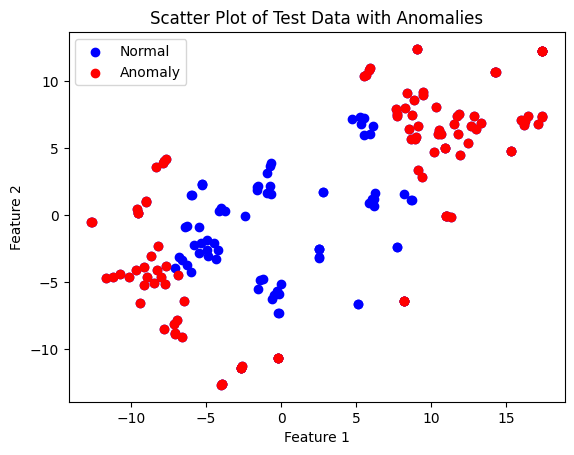

In [ ]:
import matplotlib.pyplot as plt

# Assuming X_test is your test dataset
plt.scatter(X_test[:, 0], X_test[:, 1], c='blue', label='Normal')
plt.scatter(X_test[anomalies, 0], X_test[anomalies, 1], c='red', label='Anomaly')
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Test Data with Anomalies')
plt.show()


In [ ]:
import joblib

# Save the trained model to a file
model_filename = "hybrid_model.pkl"
joblib.dump(best_autoencoder, model_filename)


['hybrid_model.pkl']